In [1]:
# An example of searching through the database of segments for a specific condition, and plotting the results.

from openpilot.data import logreader_from_repo, load_segments_data
from openpilot.tools.lib.route import SegmentName


segments_data = load_segments_data()

platform = "SUBARU OUTBACK 6TH GEN"

segments = segments_data["segments_per_platform"][platform]

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/batman


1bbe6bf2d62f58a8|2022-07-14--17-11-43--10
c3d1ccb52f5f9d65|2023-07-22--01-23-20--6


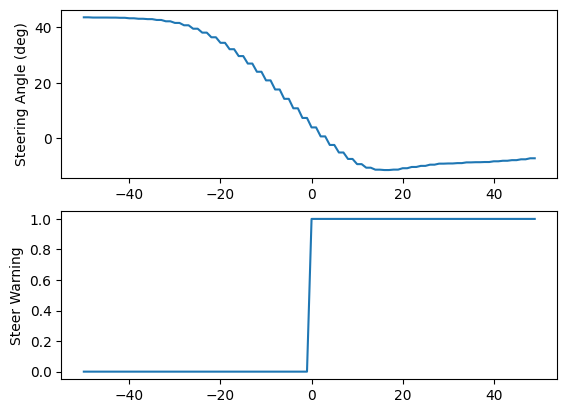

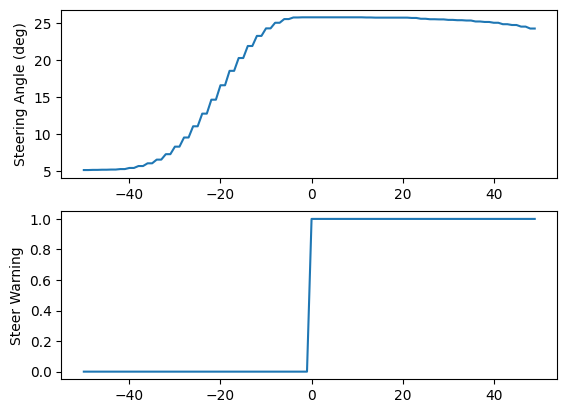

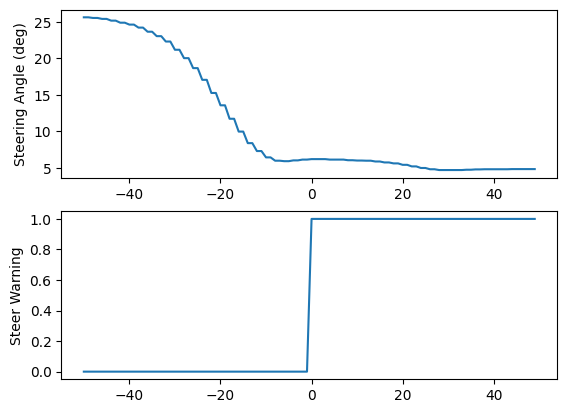

c3d1ccb52f5f9d65|2023-07-22--01-23-20--7


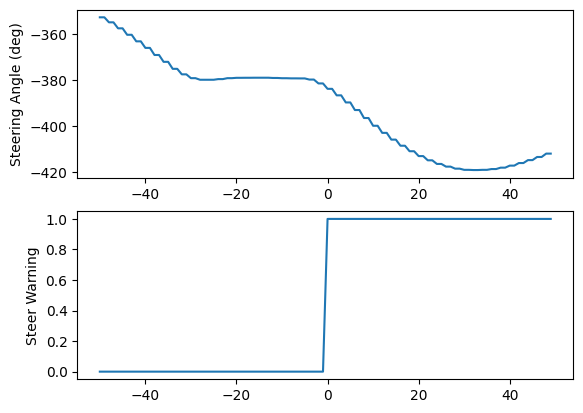

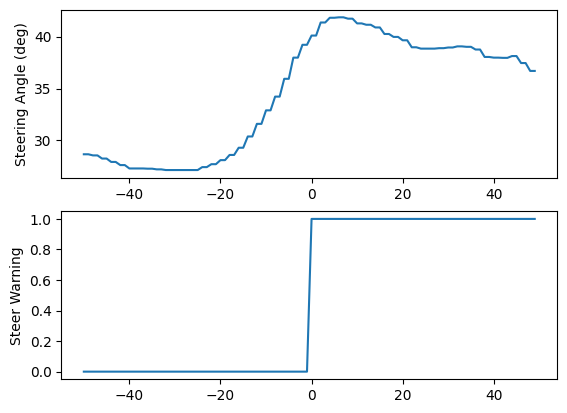

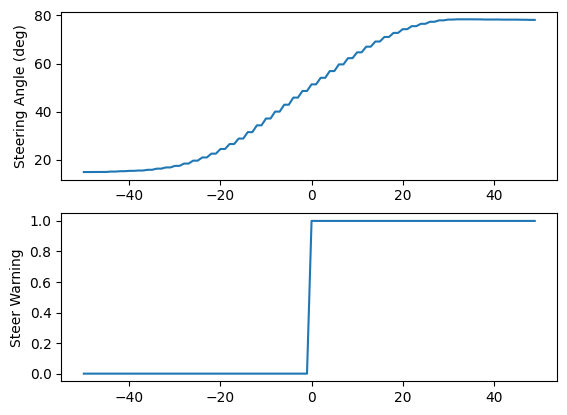

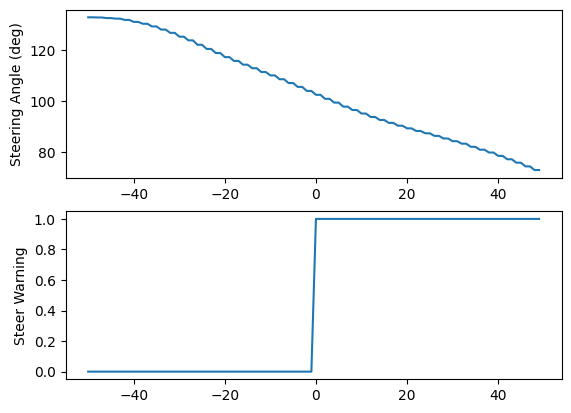

c3d1ccb52f5f9d65|2023-07-22--01-23-20--8


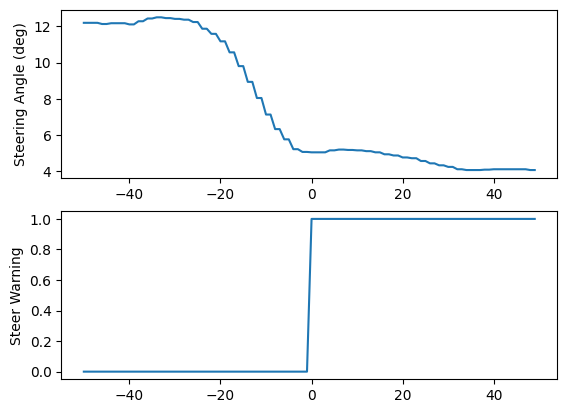

In [2]:
import copy
import matplotlib.pyplot as plt
import numpy as np


from selfdrive.car.subaru.values import CanBus, DBC

from opendbc.can.parser import CANParser

"""
In this example, we search for positive transitions of Steer_Warning, which indicate that the EPS
has stopped responding to our messages. This analysis would allow you to find the cause of these
steer warnings and potentially work around them.
"""

for segment in segments:
  print(segment)
  sn = SegmentName(segment)

  lr = logreader_from_repo(sn.route_name, sn.segment_num)

  can_msgs = [msg for msg in lr if msg.which() == "can"]

  messages = [
    ("Steering_Torque", 50)
  ]

  cp = CANParser(DBC[platform]["pt"], messages, CanBus.main)

  steering_torque_history = []
  examples = []

  for msg in can_msgs:
    cp.update_strings([msg.as_builder().to_bytes()])
    steering_torque_history.append(copy.copy(cp.vl["Steering_Torque"]))
  
  steer_warning_last = False
  for i, steering_torque_msg in enumerate(steering_torque_history):
    steer_warning = steering_torque_msg["Steer_Warning"]

    steer_angle = steering_torque_msg["Steering_Angle"]

    if steer_warning and not steer_warning_last: # positive transition of "Steer_Warning"
      examples.append(i)

    steer_warning_last = steer_warning

  FRAME_DELTA = 100 # plot this many frames around the positive transition

  for example in examples:
    fig, axs = plt.subplots(2)

    min_frame = int(example-FRAME_DELTA/2)
    max_frame = int(example+FRAME_DELTA/2)

    steering_angle_history = [msg["Steering_Angle"] for msg in steering_torque_history[min_frame:max_frame]]
    steering_warning_history = [msg["Steer_Warning"] for msg in steering_torque_history[min_frame:max_frame]]

    xs = np.arange(-FRAME_DELTA/2, FRAME_DELTA/2)

    axs[0].plot(xs, steering_angle_history)
    axs[0].set_ylabel("Steering Angle (deg)")
    axs[1].plot(xs, steering_warning_history)
    axs[1].set_ylabel("Steer Warning")

    plt.show()
